In [4]:
import trecs
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from collections import defaultdict
from chaney_utils import (
    gen_social_network, 
    mu_sigma_to_alpha_beta, 
    exclude_new_items, 
    perfect_scores,
    interleave_new_items,
    process_measurement,
    MeanDistanceSimUsers,
    MeanInteractionDistance,
    SimilarUserInteractionSimilarity,
    InteractionTracker,
    RandomRecommender,
    ChaneyContent,
    IdealRecommender
)
from creator_sim import (
    ChaneyCreators,
    ideal_content_score_fns,
    CreatorItemHomogenization
)
import warnings
warnings.simplefilter("ignore")

In [5]:
from creator_sim import (
    sample_users_and_creators,
    init_sim_state,
    run_ideal_sim,
    run_content_sim,
    run_mf_sim,
    run_sf_sim,
    run_pop_sim,
    run_random_sim
)

In [6]:
# define constants
SEED = 1234
GENERATOR = np.random.default_rng(SEED)
NUM_USERS = 100
NUM_CREATORS = 10 
ITEMS_PER_CREATOR = 1 # each creator produces 1 item per timestep
NUM_ATTRS = 20 
NUM_SIMS = 25
# parameters provided in paper 
MU_N = 0.98 
SIGMA = 1e-5
DEBUG = True # if True, figures will not be written to files

## Generate synthetic data

In [7]:
users, creators, social_networks = sample_users_and_creators(
    GENERATOR, 
    NUM_USERS, 
    NUM_CREATORS, 
    NUM_ATTRS, 
    NUM_SIMS
)

# Experiments

In [8]:
model_keys = ["ideal", "content_chaney", "mf", "sf", "popularity", "random"]
# stores results for each type of model for each type of user pairing (random or cosine similarity)
rep_train_results = {"mean_item_dist": defaultdict(list), "sim_user_dist": defaultdict(list)}
rep_train_models = {}

# stores results for each type of model for each type of user pairing (random or cosine similarity)
single_train_results = {"mean_item_dist": defaultdict(list), "sim_user_dist": defaultdict(list)}
single_train_models = {}

# mostly for plotting
id_to_readable = {
    "ideal": "ideal", 
    "content_chaney": "content filtering",
    "mf" : "matrix factorization",
    "sf": "social filtering",
    "popularity": "popularity", 
    "random": "random"
}

## Repeated training

In [6]:
sim_args = {
    "startup_iters": 10,
    "sim_iters": 90,
    "repeated_training": True,
    "new_items_per_iter": 10,
    "attention_exp": -0.8, # from Chaney paper, attention function is f(n) = n^(-0.8)
    "num_users": NUM_USERS, 
    "num_attrs": NUM_ATTRS,
    "num_creators": NUM_CREATORS,
    "items_per_creator": ITEMS_PER_CREATOR,
    "sigma": SIGMA,
    "mu_n": MU_N,
    "learning_rate": 0.0005,
}

In [38]:
for i in range(NUM_SIMS):
    true_prefs = users[i] # underlying true preferences
    creator_profiles = creators[i]
    social_network = social_networks[i]

    # generate random pairs for evaluating jaccard similarity
    pairs = [GENERATOR.choice(NUM_USERS, 2, replace=False) for _ in range(800)]
        
    rep_train_models["ideal"] = run_ideal_sim(true_prefs, creator_profiles, pairs, sim_args, GENERATOR)
    ideal_interactions = np.hstack(process_measurement(rep_train_models["ideal"], "interaction_history")) # pull out the interaction history for the ideal simulations
    ideal_attrs = rep_train_models["ideal"].actual_item_attributes
    rep_train_models["content_chaney"] = run_content_sim(true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, sim_args, GENERATOR)
    rep_train_models["mf"] = run_mf_sim(true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, sim_args, GENERATOR)
    rep_train_models["sf"] = run_sf_sim(social_network, true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, sim_args, GENERATOR)
    rep_train_models["popularity"] = run_pop_sim(true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, sim_args, GENERATOR)
    rep_train_models["random"] = run_random_sim(true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, sim_args, GENERATOR)
    
    # extract results from each model
    for model_key in model_keys:
        model = rep_train_models[model_key]
        rep_train_results["mean_item_dist"][model_key].append(process_measurement(model, "mean_interaction_dist"))
        if model_key is not "ideal": # homogenization of similar users is always measured relative to the ideal model
            rep_train_results["sim_user_dist"][model_key].append(process_measurement(model, "sim_user_dist"))

100%|██████████| 90/90 [00:11<00:00,  7.59it/s]


In [7]:
# for plotting purposes
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 14})
smooth_sigma = 1.0

In [8]:
def graph_relative_to_ideal(train_results, metric_key, model_keys, label_map, absolute_measure=True, smooth_sigma=1):
    relative_dist = {}
    
    if absolute_measure:
        ideal_dist = np.array(train_results[metric_key]["ideal"])
    else:
        model_key = list(train_results[metric_key].keys())[0]
        # zeros for all timsteps
        timesteps = len(train_results[metric_key][model_key][0])
        ideal_dist = np.zeros(timesteps)
        relative_dist["ideal"] = ideal_dist

    for model_key in model_keys:
        if model_key is "ideal" and not absolute_measure:
            continue
            
        abs_dist = np.array(train_results[metric_key][model_key])
        if absolute_measure:
            abs_dist = abs_dist - ideal_dist
        relative_dist[model_key] = abs_dist.mean(axis=0) # average across 10 trials
        
    for m in model_keys:
        plt.plot(gaussian_filter1d(relative_dist[m], sigma=smooth_sigma), label=label_map[m])
    plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))

In [9]:
def transform_relative_to_ideal(train_results, metric_key, model_keys, absolute_measure=True):
    relative_dist = {}
    
    if absolute_measure:
        ideal_dist = np.array(train_results[metric_key]["ideal"])
    else:
        model_key = list(train_results[metric_key].keys())[0]
        # zeros for all timsteps
        trials = len(train_results[metric_key][model_key])
        timesteps = len(train_results[metric_key][model_key][0])
        ideal_dist = np.zeros((trials, timesteps))
        relative_dist["ideal"] = ideal_dist

    for model_key in model_keys:
        if model_key is "ideal" and not absolute_measure:
            continue
            
        abs_dist = np.array(train_results[metric_key][model_key])
        if absolute_measure:
            abs_dist = abs_dist - ideal_dist
        relative_dist[model_key] = abs_dist
    return relative_dist

def graph_relative_to_ideal(train_results, metric_key, model_keys, label_map, absolute_measure=True):
    relative_dist = transform_relative_to_ideal(train_results, metric_key, model_keys, absolute_measure)
    # average across trials
    for model_key in model_keys:
        relative_dist[model_key] = relative_dist[model_key].mean(axis=0)
    
    for m in model_keys:
        plt.plot(gaussian_filter1d(relative_dist[m], sigma=smooth_sigma), label=label_map[m])
    plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
    
def last_timestep_values(train_results, metric_key, model_keys, absolute_measure=True):
    relative_dist = transform_relative_to_ideal(train_results, metric_key, model_keys, absolute_measure)
    for model_key in relative_dist.keys():
        # just take out last value 
        relative_dist[model_key] = relative_dist[model_key][:, -1]
        sd = relative_dist[model_key].std()
        print(f"Mean value of {metric_key} for model {model_key}: {relative_dist[model_key].mean(axis=0):.2f} (sd: {sd:.3f})")
        
    return relative_dist

### Average distance between mean items

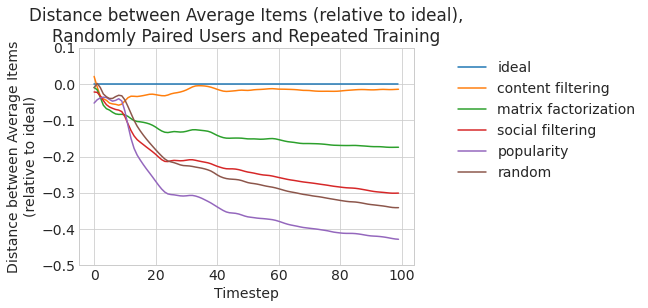

In [48]:
graph_relative_to_ideal(rep_train_results, "mean_item_dist", model_keys, id_to_readable)
plt.ylabel("Distance between Average Items\n(relative to ideal)")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.5, 0.1)
plt.title("Distance between Average Items (relative to ideal),\nRandomly Paired Users and Repeated Training")
if not DEBUG:
    plt.savefig('./figures/creator_repeated_training_mean_dist_rand_pair.pdf', bbox_inches = "tight")

### Change in Mean Item Distance (similar users paired)

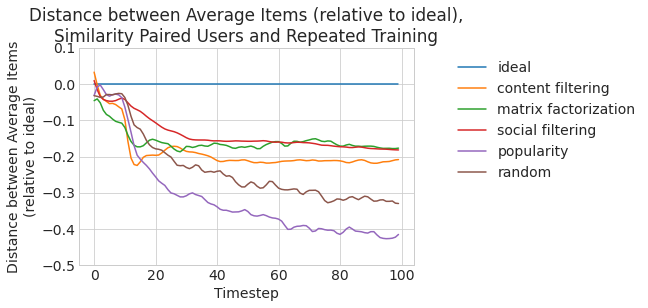

In [51]:
graph_relative_to_ideal(rep_train_results, "sim_user_dist", model_keys, id_to_readable, absolute_measure=False)
plt.ylabel("Distance between Average Items\n(relative to ideal)")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.5, 0.1)
plt.title("Distance between Average Items (relative to ideal),\nSimilarity Paired Users and Repeated Training")
if not DEBUG:
    plt.savefig('./figures/creator_repeated_training_mean_dist_sim_pair.pdf', bbox_inches = "tight")

## Single training

In [52]:
sim_args = {
    "startup_iters": 50,
    "sim_iters": 50,
    "repeated_training": False,
    "new_items_per_iter": 10,
    "attention_exp": -0.8, # from Chaney paper, attention function is f(n) = n^(-0.8)
    "num_users": NUM_USERS, 
    "num_attrs": NUM_ATTRS,
    "num_creators": NUM_CREATORS,
    "items_per_creator": ITEMS_PER_CREATOR,
    "sigma": SIGMA,
    "mu_n": MU_N,
    "learning_rate": 0.0005,
}


In [53]:
for i in range(NUM_SIMS):
    true_prefs = users[i] # underlying true preferences
    creator_profiles = creators[i]
    social_network = social_networks[i]

    # generate random pairs for evaluating jaccard similarity
    pairs = [GENERATOR.choice(NUM_USERS, 2, replace=False) for _ in range(800)]
        
    single_train_models["ideal"] = run_ideal_sim(true_prefs, creator_profiles, pairs, sim_args, GENERATOR)
    ideal_interactions = np.hstack(process_measurement(single_train_models["ideal"], "interaction_history")) # pull out the interaction history for the ideal simulations
    ideal_attrs = single_train_models["ideal"].actual_item_attributes
    single_train_models["content_chaney"] = run_content_sim(true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, sim_args, GENERATOR)
    single_train_models["mf"] = run_mf_sim(true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, sim_args, GENERATOR)
    single_train_models["sf"] = run_sf_sim(social_network, true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, sim_args, GENERATOR)
    single_train_models["popularity"] = run_pop_sim(true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, sim_args, GENERATOR)
    single_train_models["random"] = run_random_sim(true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, sim_args, GENERATOR)
    
    # extract results from each model
    for model_key in model_keys:
        model = single_train_models[model_key]
        single_train_results["mean_item_dist"][model_key].append(process_measurement(model, "mean_interaction_dist"))
        if model_key is not "ideal": # homogenization of similar users is always measured relative to the ideal model
            single_train_results["sim_user_dist"][model_key].append(process_measurement(model, "sim_user_dist"))

100%|██████████| 50/50 [00:07<00:00,  6.34it/s]


### Average distance between mean items

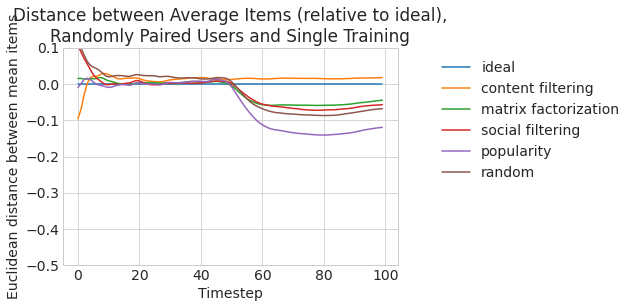

In [54]:
graph_relative_to_ideal(single_train_results, "mean_item_dist", model_keys, id_to_readable)

plt.ylabel("Euclidean distance between mean items")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.5, 0.1)
plt.title("Distance between Average Items (relative to ideal),\nRandomly Paired Users and Single Training")
if not DEBUG:
    plt.savefig('./figures/creator_single_training_mean_dist_rand_pair.pdf', bbox_inches = "tight")

### Change in Mean Item Distance (similar users paired)

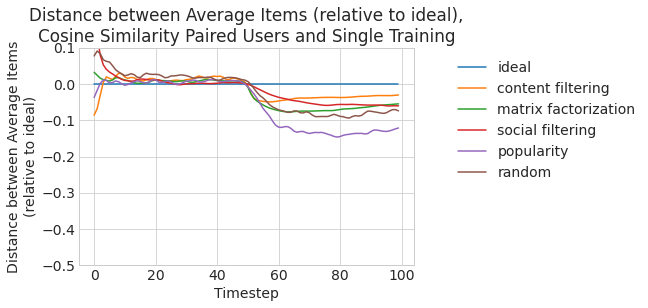

In [55]:
graph_relative_to_ideal(single_train_results, "sim_user_dist", model_keys, id_to_readable, absolute_measure=False)

plt.ylabel("Distance between Average Items\n(relative to ideal)")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.5, 0.1)
plt.title("Distance between Average Items (relative to ideal),\nCosine Similarity Paired Users and Single Training")
if not DEBUG:
    plt.savefig('./figures/creator_single_training_mean_dist_sim_pair.pdf', bbox_inches = "tight")

# Experimental analysis

## Scratch work: examine dynamic content creators

In [27]:
from scipy import stats

In [36]:
NUM_USERS = 100
NUM_CREATORS = 5 
ITEMS_PER_CREATOR = 1 # each creator produces 1 item per timestep
NUM_ATTRS = 5 
NUM_SIMS = 25
# parameters provided in paper 
MU_N = 0.98 
SIGMA = 1e-5

users, creators, social_networks = sample_users_and_creators(
    GENERATOR, 
    NUM_USERS, 
    NUM_CREATORS, 
    NUM_ATTRS, 
    NUM_SIMS
)

args = {
    "startup_iters": 10,
    "sim_iters": 300,
    "repeated_training": True,
    "new_items_per_iter": NUM_CREATORS * ITEMS_PER_CREATOR,
    "attention_exp": -0.8, # from Chaney paper, attention function is f(n) = n^(-0.8)
    "num_users": NUM_USERS, 
    "num_attrs": NUM_ATTRS,
    "num_creators": NUM_CREATORS,
    "items_per_creator": ITEMS_PER_CREATOR,
    "sigma": SIGMA,
    "mu_n": MU_N,
    "learning_rate": 0.0005,
}

user_prefs = users[0]
creator_profiles = creators[0]
social_network = social_networks[0]

u, c, empty_items, init_params, run_params = init_sim_state(user_prefs, creator_profiles, args, GENERATOR)
if args["repeated_training"]:
    post_startup_rec_size = "all"
else: # only serve items that were in the initial training set
    total_items_in_startup = (args["items_per_creator"] * args["num_creators"]) * args["startup_iters"]
    post_startup_rec_size = total_items_in_startup + args["new_items_per_iter"] # show all items from training set plus interleaved items
model_score_fn, user_score_fn = ideal_content_score_fns(args["sigma"], args["mu_n"], args["new_items_per_iter"], GENERATOR)
ideal = IdealRecommender(
    user_representation=user_prefs,
    creators=c, 
    actual_user_representation=u,
    actual_item_representation=empty_items,
    score_fn=model_score_fn,
    **init_params
)


# set score function here because it requires a reference to the recsys
ideal.users.set_score_function(user_score_fn)
ideal.add_metrics(CreatorItemHomogenization())
ideal.startup_and_train(timesteps=args["startup_iters"])
    
    
ideal.set_num_items_per_iter(post_startup_rec_size)
num_steps = 100
for i in range(round(args["sim_iters"] / num_steps)):
#     import pdb; pdb.set_trace()
    ideal.run(timesteps=num_steps, train_between_steps=args["repeated_training"], **run_params)
    
ideal.close()
# ideal.startup_and_train(timesteps=args["startup_iters"])
# ideal.set_num_items_per_iter(post_startup_rec_size) # show all items from training set plus interleaved items
# ideal.run(timesteps=args["sim_iters"], train_between_steps=args["repeated_training"], **run_params)
# ideal.close()

100%|██████████| 100/100 [00:10<00:00,  9.73it/s]


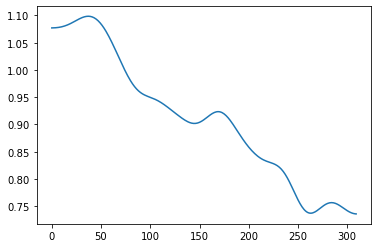

In [40]:
plt.plot(gaussian_filter1d(np.array(process_measurement(ideal, "creator_item_homo")), sigma=15))

In [44]:
ideal.creators.actual_creator_profiles

array([[0.00709972, 0.10069608, 0.02904462, 0.43334439, 0.42981519],
       [0.0131254 , 0.01053632, 0.02191717, 0.86824778, 0.08617332],
       [0.00922169, 0.14667146, 0.0539666 , 0.73728895, 0.05285129],
       [0.02159336, 0.16945703, 0.07474523, 0.40115371, 0.33305068],
       [0.0174978 , 0.25731155, 0.04239106, 0.23790574, 0.44489384]])

In [45]:
ideal.items.value[:, 0:10].T.round(decimals=2)

array([[0.  , 1.  , 0.  , 0.  , 0.  ],
       [0.93, 0.  , 0.  , 0.07, 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  ]])

In [46]:
ideal.items.value[:, 1490:1500].T.round(decimals=2)

array([[0.  , 0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.03, 0.97],
       [0.  , 0.01, 0.  , 0.99, 0.  ],
       [0.  , 0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.26, 0.  , 0.74],
       [0.  , 0.  , 0.  , 0.  , 1.  ]])

In [41]:
from scipy.spatial.distance import pdist

In [42]:
# measure item homogenization at each timestep

pdist_vals = []
num_steps = 1
for i in range(round(ideal.items.shape[1] / (NUM_CREATORS * num_steps))):
    timestep_items = ideal.items.value[:, i*(NUM_CREATORS*num_steps):(i+1)*(NUM_CREATORS*num_steps)].T
    pdist_vals.append(pdist(timestep_items).mean())

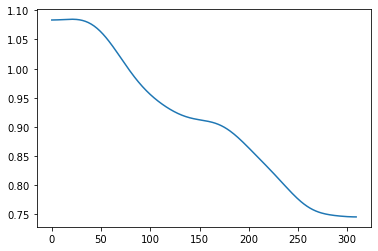

In [43]:
plt.plot(gaussian_filter1d(pdist_vals, sigma=25))

In [14]:
results = load_sim_results("exps/creator_hom_rep_500")

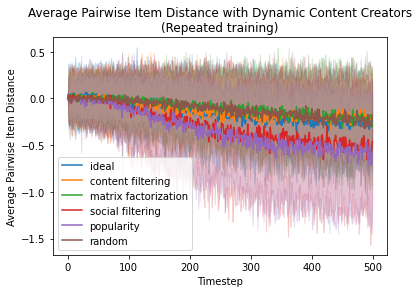

In [37]:
for m in model_keys:
    x = np.array(results['creator_item_homo'][m])
    z = (x - x[:, 0][:, np.newaxis]).mean(axis=0)
    std = (x - x[:, 0][:, np.newaxis]).std(axis=0)
#     sem = stats.sem(x - x[:, 0][:, np.newaxis], axis=0)
    line = plt.plot(z, label=id_to_readable[m])
    line_c = line[0].get_color()
    # 95% CI = +- 1.96 * SEM
    mult = 1.96
#     mult = 1
    plt.fill_between(np.arange(500), z - mult * std, z + mult * std, color = line_c+"30")

    plt.ylabel("Average Pairwise Item Distance")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.title("Average Pairwise Item Distance with Dynamic Content Creators\n(Repeated training)")
# plt.ylim((0.7, 1.35))
plt.legend()
plt.savefig("figures/creator_repeated_item_homo.pdf")

In [29]:
results.keys()

dict_keys(['creator_item_homo'])

In [34]:
results = load_sim_results("exps/creator_hom_single_500")

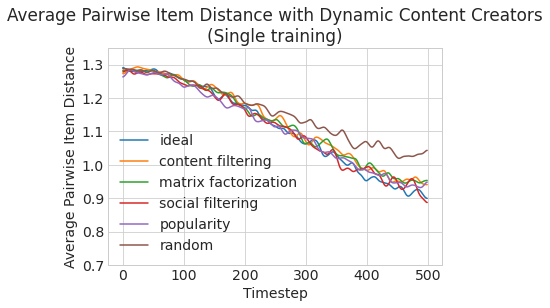

In [38]:
for m in model_keys:
    plt.plot(gaussian_filter1d(np.array(results['creator_item_homo'][m]).mean(axis=0), sigma=5), label=id_to_readable[m])
plt.ylabel("Average Pairwise Item Distance")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.title("Average Pairwise Item Distance with Dynamic Content Creators\n(Single training)")
plt.ylim((0.7, 1.35))
plt.legend()

## Exploration of results with different learning rates

In [12]:
import pickle as pkl
import os

In [18]:
lr_to_folder = {
    1e-3: {
        "repeated": "exps/lr_1e-3_rep",
        "single": "exps/lr_1e-3_single",
    },
    1e-4: {
        "repeated": "exps/lr_1e-4_rep",
        "single": "exps/lr_1e-4_single",
    },
    5e-4: {
        "repeated": "exps/lr_5e-4_rep",
        "single": "exps/lr_5e-4_single",
    },
    7e-4: {
        "repeated": "exps/lr_7e-4_rep",
        "single": "exps/lr_7e-4_single",
    },
    5e-5: {
        "repeated": "exps/lr_5e-5_rep",
        "single": "exps/lr_5e-5_single",
    }
}

In [13]:
def load_sim_results(folder):
    filepath = os.path.join(folder, "sim_results.pkl")
    return pkl.load(open(filepath, "rb"))

## Content creators with varying learning rates

For now, we only look at the cases where we pair users by cosine similarity.

### LR = 0.00005

Text(0.5, 1.0, 'Distance between Average Items, LR=5e-5,\nCosine Similarity Paired Users and Repeated Training')

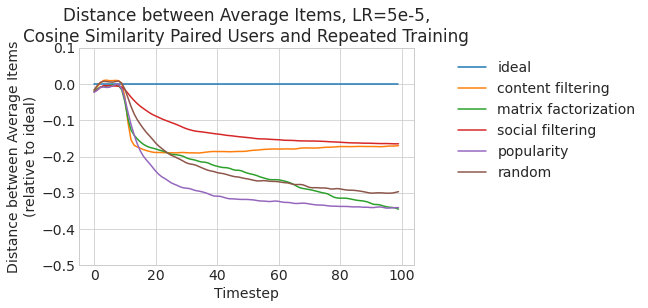

In [13]:
results = load_sim_results(lr_to_folder[5e-5]["repeated"])
graph_relative_to_ideal(results, "sim_user_dist", model_keys, id_to_readable, absolute_measure=False)
plt.ylabel("Distance between Average Items\n(relative to ideal)")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.5, 0.1)
plt.title("Distance between Average Items, LR=5e-5,\nCosine Similarity Paired Users and Repeated Training")

In [14]:
last_timestep_dist = last_timestep_values(results, "sim_user_dist", model_keys, absolute_measure=False)

Mean value of sim_user_dist for model ideal: 0.00 (sd: 0.000)
Mean value of sim_user_dist for model content_chaney: -0.17 (sd: 0.030)
Mean value of sim_user_dist for model mf: -0.35 (sd: 0.036)
Mean value of sim_user_dist for model sf: -0.16 (sd: 0.031)
Mean value of sim_user_dist for model popularity: -0.34 (sd: 0.038)
Mean value of sim_user_dist for model random: -0.30 (sd: 0.045)


Text(0.5, 1.0, 'Distance between Average Items, LR=5e-5,\nCosine Similarity Paired Users and Repeated Training')

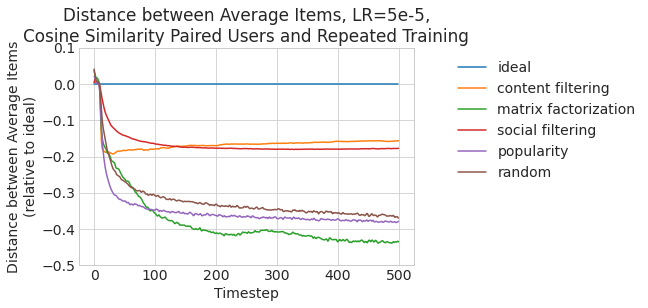

In [55]:
results = load_sim_results(lr_to_folder[5e-5]["repeated"] + "_500")
graph_relative_to_ideal(results, "sim_user_dist", model_keys, id_to_readable, absolute_measure=False)
plt.ylabel("Distance between Average Items\n(relative to ideal)")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.5, 0.1)
plt.title("Distance between Average Items, LR=5e-5,\nCosine Similarity Paired Users and Repeated Training")

### LR = 0.0001

Text(0.5, 1.0, 'Distance between Average Items, LR=1e-4,\nCosine Similarity Paired Users and Repeated Training')

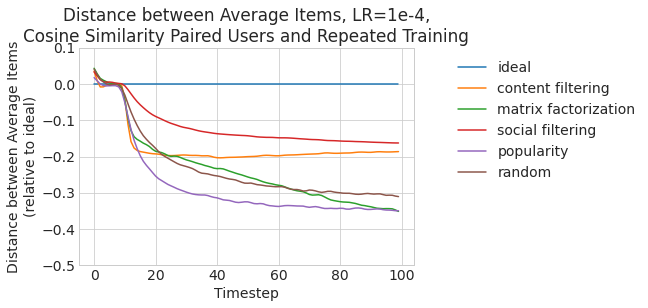

In [15]:
results = load_sim_results(lr_to_folder[1e-4]["repeated"])
graph_relative_to_ideal(results, "sim_user_dist", model_keys, id_to_readable, absolute_measure=False)
plt.ylabel("Distance between Average Items\n(relative to ideal)")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.5, 0.1)
plt.title("Distance between Average Items, LR=1e-4,\nCosine Similarity Paired Users and Repeated Training")

Text(0.5, 1.0, 'Distance between Average Items, LR=1e-4,\nCosine Similarity Paired Users and Repeated Training')

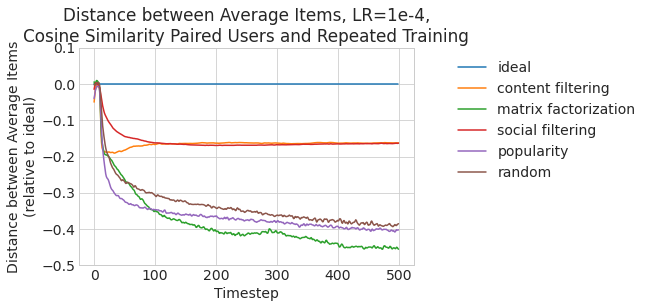

In [54]:
results = load_sim_results(lr_to_folder[1e-4]["repeated"] + "_500")
graph_relative_to_ideal(results, "sim_user_dist", model_keys, id_to_readable, absolute_measure=False)
plt.ylabel("Distance between Average Items\n(relative to ideal)")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.5, 0.1)
plt.title("Distance between Average Items, LR=1e-4,\nCosine Similarity Paired Users and Repeated Training")

In [16]:
last_timestep_dist = last_timestep_values(results, "sim_user_dist", model_keys, absolute_measure=False)

Mean value of sim_user_dist for model ideal: 0.00 (sd: 0.000)
Mean value of sim_user_dist for model content_chaney: -0.19 (sd: 0.040)
Mean value of sim_user_dist for model mf: -0.35 (sd: 0.050)
Mean value of sim_user_dist for model sf: -0.16 (sd: 0.027)
Mean value of sim_user_dist for model popularity: -0.35 (sd: 0.037)
Mean value of sim_user_dist for model random: -0.31 (sd: 0.047)


### LR = 0.0005

Text(0.5, 1.0, 'Distance between Average Items, LR=5e-4,\nCosine Similarity Paired Users and Repeated Training')

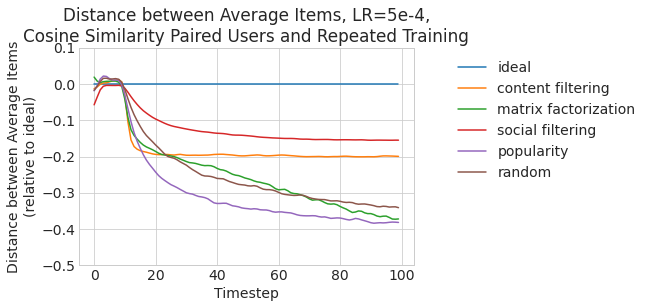

In [17]:
results = load_sim_results(lr_to_folder[5e-4]["repeated"])
graph_relative_to_ideal(results, "sim_user_dist", model_keys, id_to_readable, absolute_measure=False)
plt.ylabel("Distance between Average Items\n(relative to ideal)")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.5, 0.1)
plt.title("Distance between Average Items, LR=5e-4,\nCosine Similarity Paired Users and Repeated Training")

Text(0.5, 1.0, 'Distance between Average Items, LR=5e-5,\nCosine Similarity Paired Users and Repeated Training')

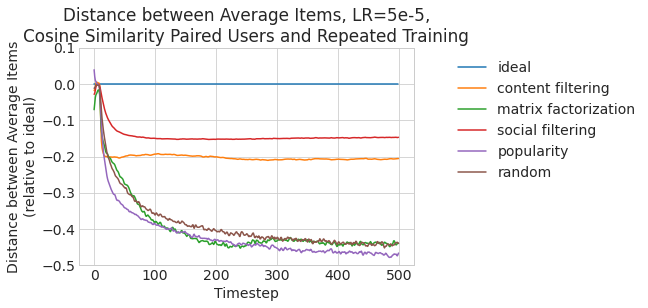

In [56]:
results = load_sim_results(lr_to_folder[5e-4]["repeated"] + "_500")
graph_relative_to_ideal(results, "sim_user_dist", model_keys, id_to_readable, absolute_measure=False)
plt.ylabel("Distance between Average Items\n(relative to ideal)")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.5, 0.1)
plt.title("Distance between Average Items, LR=5e-5,\nCosine Similarity Paired Users and Repeated Training")

In [18]:
last_timestep_dist = last_timestep_values(results, "sim_user_dist", model_keys, absolute_measure=False)

Mean value of sim_user_dist for model ideal: 0.00 (sd: 0.000)
Mean value of sim_user_dist for model content_chaney: -0.20 (sd: 0.039)
Mean value of sim_user_dist for model mf: -0.37 (sd: 0.052)
Mean value of sim_user_dist for model sf: -0.16 (sd: 0.031)
Mean value of sim_user_dist for model popularity: -0.38 (sd: 0.043)
Mean value of sim_user_dist for model random: -0.34 (sd: 0.032)


In [41]:
# Compare across learning rates
# store sim user homogenization for last timestep
last_timestep_sim = {}
for lr in lr_to_folder.keys():
    print(f"LR: {lr}")
    results = load_sim_results(lr_to_folder[lr]["repeated"])
    last_timestep_sim[lr] = last_timestep_values(results, "sim_user_dist", model_keys, absolute_measure=False)
    print("")

LR: 0.001
Mean value of sim_user_dist for model ideal: 0.00 (sd: 0.000)
Mean value of sim_user_dist for model content_chaney: -0.23 (sd: 0.044)
Mean value of sim_user_dist for model mf: -0.40 (sd: 0.055)
Mean value of sim_user_dist for model sf: -0.14 (sd: 0.029)
Mean value of sim_user_dist for model popularity: -0.42 (sd: 0.053)
Mean value of sim_user_dist for model random: -0.40 (sd: 0.059)

LR: 0.0001
Mean value of sim_user_dist for model ideal: 0.00 (sd: 0.000)
Mean value of sim_user_dist for model content_chaney: -0.19 (sd: 0.040)
Mean value of sim_user_dist for model mf: -0.35 (sd: 0.050)
Mean value of sim_user_dist for model sf: -0.16 (sd: 0.027)
Mean value of sim_user_dist for model popularity: -0.35 (sd: 0.037)
Mean value of sim_user_dist for model random: -0.31 (sd: 0.047)

LR: 0.0005
Mean value of sim_user_dist for model ideal: 0.00 (sd: 0.000)
Mean value of sim_user_dist for model content_chaney: -0.20 (sd: 0.039)
Mean value of sim_user_dist for model mf: -0.37 (sd: 0.052)


In [42]:
from scipy import stats
np.random.seed(12345678)
lr1 = 5e-5
lr2 = 0.001
# t-test for value at last timestep
# look at similar user homogenization
for m in model_keys:
    if m is not "ideal":
        lr1_mean = last_timestep_sim[lr1][m].mean()
        lr2_mean = last_timestep_sim[lr2][m].mean()
        print(f"MODEL: {m}")
        print(f"Mean in lr={lr1}: {lr1_mean:.2f}, Mean in lr={lr2}: {lr2_mean:.2f}")
        print(stats.ttest_ind(last_timestep_sim[5e-5][m], last_timestep_sim[0.001][m], equal_var=False))
        print()

MODEL: content_chaney
Mean in lr=5e-05: -0.17, Mean in lr=0.001: -0.23
Ttest_indResult(statistic=5.579953668395723, pvalue=1.5576688536704972e-06)

MODEL: mf
Mean in lr=5e-05: -0.35, Mean in lr=0.001: -0.40
Ttest_indResult(statistic=3.948107349960929, pvalue=0.00029828542212515213)

MODEL: sf
Mean in lr=5e-05: -0.16, Mean in lr=0.001: -0.14
Ttest_indResult(statistic=-2.8290198496500203, pvalue=0.006802223596000047)

MODEL: popularity
Mean in lr=5e-05: -0.34, Mean in lr=0.001: -0.42
Ttest_indResult(statistic=6.027655357203423, pvalue=3.153784339215864e-07)

MODEL: random
Mean in lr=5e-05: -0.30, Mean in lr=0.001: -0.40
Ttest_indResult(statistic=6.738323885565758, pvalue=2.4988981693718806e-08)



In [47]:
# Compare across learning rates
# store sim user homogenization for last timestep
last_timestep_mid = {}
for lr in lr_to_folder.keys():
    print(f"LR: {lr}")
    results = load_sim_results(lr_to_folder[lr]["repeated"])
    last_timestep_mid[lr] = last_timestep_values(results, "mean_item_dist", model_keys, absolute_measure=False)
    print("")

from scipy import stats
np.random.seed(12345678)
lr1 = 5e-5
lr2 = 0.001
# t-test for value at last timestep
# look at global homogenization
for m in model_keys:
    if m is not "ideal":
        lr1_mean = last_timestep_mid[lr1][m].mean()
        lr2_mean = last_timestep_mid[lr2][m].mean()
        print(f"MODEL: {m}")
        print(f"Mean in lr={lr1}: {lr1_mean:.2f}, Mean in lr={lr2}: {lr2_mean:.2f}")
        print(stats.ttest_ind(last_timestep_mid[5e-5][m], last_timestep_mid[0.001][m], equal_var=False))
        print()

LR: 0.001
Mean value of mean_item_dist for model ideal: 0.00 (sd: 0.000)
Mean value of mean_item_dist for model content_chaney: 0.79 (sd: 0.037)
Mean value of mean_item_dist for model mf: 0.30 (sd: 0.018)
Mean value of mean_item_dist for model sf: 0.51 (sd: 0.112)
Mean value of mean_item_dist for model popularity: 0.35 (sd: 0.071)
Mean value of mean_item_dist for model random: 0.39 (sd: 0.024)

LR: 0.0001
Mean value of mean_item_dist for model ideal: 0.00 (sd: 0.000)
Mean value of mean_item_dist for model content_chaney: 0.70 (sd: 0.042)
Mean value of mean_item_dist for model mf: 0.30 (sd: 0.020)
Mean value of mean_item_dist for model sf: 0.48 (sd: 0.083)
Mean value of mean_item_dist for model popularity: 0.34 (sd: 0.052)
Mean value of mean_item_dist for model random: 0.38 (sd: 0.018)

LR: 0.0005
Mean value of mean_item_dist for model ideal: 0.00 (sd: 0.000)
Mean value of mean_item_dist for model content_chaney: 0.75 (sd: 0.043)
Mean value of mean_item_dist for model mf: 0.31 (sd: 0.02

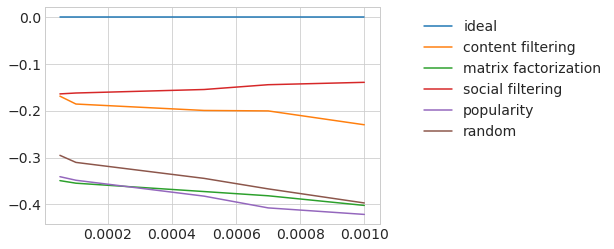

In [52]:
# graph learning rate against sim user / global homogenization
lrs = sorted(list(lr_to_folder.keys()))
mean_sim_homog = defaultdict(list)
mean_glob_homog = defaultdict(list)

for lr in lrs:
    # create array for each model type
    for m in model_keys:
        mean_sim_homog[m].append(last_timestep_sim[lr][m].mean())
        mean_glob_homog[m].append(last_timestep_mid[lr][m].mean())

# for model_key in model_keys:
#         relative_dist[model_key] = relative_dist[model_key].mean(axis=0)
    
for m in model_keys:
    plt.plot(lrs, mean_sim_homog[m], label=id_to_readable[m])
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))

plt.ylabel("Distance between Average Items\n(relative to ideal)")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.5, 0.1)
plt.title("Distance between Average Items (relative to ideal),\nCosine Similarity Paired Users and Single Training")